# Instalar nltk

In [ ]:
# Correr aquí
!pip install nltk

In [1]:
# from __future__ import print_function
import spaghetti as sgt
import re
import nltk
import numpy as np
import json

### Descargar los corpus
```python 
nltk.download()
```

### archivos contenidos en carpeta
- spaghetti.py
- facturaskeys.json
- entendimiento.ipynb

### definicion de palabras asociadas a los campos y de patrones de expresiones regulares

In [62]:
dictfacturas = json.load(open("facturaskeys.json"))
print(dictfacturas)

patterns = dict(Cuenta=r"\b[A-Za-z]{3}\d{3}\b",
                Prefijo=r"\b[1-9a-zA-Z]\w{0,3}\b",  # wvect
                NoDocumento=r"\b[0-9a-zA-Z\-]{1,40}\b",  # w2vect
                NitAdquirienteMex=r"\b[A-Za-z]{4}\d{6}[A-Za-z0-9]{3}\b",
                Inicio=r".+",
                Folio=r"\d{1,16}")

{'Prefijo': ['prefijo', 'serie'], 'NoDocumento': ['documento', 'documentos', 'nota', 'notas', 'credito', 'creditos', 'facturas', 'factura', 'numero'], 'Folio': ['folio', 'folios'], 'Inicio': ['inicial', 'inicio', 'comienza', 'empieza', 'principio', 'arranque', 'inicia', 'inicien', 'inician']}


### NOTA: 

    Añadir al archivo facturaskeys.json los sinónimos que crean necesarios para cada campo, 
    respetando la estructura json

### funciones

In [64]:
def regexextractor(expression, field):
    pattern = patterns[field]
    result = re.search(pattern=pattern, string=expression)
    if result:
        return result.group()
    else:
        return None

def do_tagging(exp, field):
    tokens = nltk.word_tokenize(exp)
    tagged = sgt.pos_tag(tokens)
    tagged = np.array([list(tup) for tup in tagged]).astype(str)
    mask = tagged[:, 1] == 'None'
    for i, token in enumerate(tokens):
        if token in dictfacturas[field]:
            tagged[i, 1] = str(field)
    unknowns, = np.where(mask)
    for unknown in unknowns:
        if tagged[unknown, 0] in dictfacturas[field]:
            tagged[unknown, 1] = field
        else:
            if regexextractor(tokens[unknown], field) is not None:
                tagged[unknown, 1] = "dato"
            else:
                tagged[unknown, 1] = "unknown"
    return [tuple(wordtagged) for wordtagged in tagged]
#tag = inicio [palabras]

def do_chunking(grammar, tagged, field, code):
    cp = nltk.RegexpParser(grammar)
    chunked = cp.parse(tagged)
    # añadir las condiciones que sean necesarias para contemplar
    # los posibles valores
    posibles = ["dato", "Z", "ncfs000", "ncms000", "Fz",
                "sps00"]
    # posibles son los tipos de palabras que pueden representar al dato
    continuous_chunk = []
    entity = []
    unknowns = []
    subt = []
    for i, subtree in enumerate(chunked):
        if isinstance(subtree, nltk.Tree) and subtree.label() == "NP":
            # añadir las condiciones que sean necesarias para contemplar los posibles valores
            entity += [token for token, pos in subtree.leaves()
                       if pos in posibles]
            unknowns += [token for token, pos in subtree.leaves()
                         if pos == "unknown"]
            subt.append(subtree)
    if entity == []:
        code = 0
        if len(unknowns) > 1:
            entity = unknowns[-1].upper()
        elif unknowns != []:
            entity = unknowns[0].upper()
        else:
            entity = None
    elif len(entity) > 1:
        code = 0
        entity = entity[-1].upper()
    else:
        entity = entity[0].upper()
        if regexextractor(entity, field) is not None:
            code = 1
        else:
            code = 0
    return entity, code, subt, tagged

In [141]:
sgt.pos_tag("quiero las facturas de hoy con folio de inicio 1234".split())

[('quiero', 'vmip1s0'),
 ('las', 'da0fp0'),
 ('facturas', None),
 ('de', 'sps00'),
 ('hoy', 'rg'),
 ('con', 'sps00'),
 ('folio', None),
 ('de', 'sps00'),
 ('inicio', 'ncms000'),
 ('1234', None)]

### NOTA: 
      
      la palabra prefijo no está en el diccionario, por lo tanto como es detectada como desconocida 
      pero cumple con la expresión regular del campo, la asigna como posible dato

# Ejemplo de grammar

```python
grammar = r"""Q: {<dato|Z|Fz|unknown|ncfs000>}
              T: {<dato|Fz|unknown|sps00>}
              NP: {<Prefijo> <(vs\w+)|(nc\w+)|(wmi\w+)|(spc\w+)>* <Q>}
              NP: {<Prefijo> <T>}
              NP: {<Prefijo> <(vmi\w+)|(aq\w+)|unknown>? <sp\w+>? <Q>}
              NP: {<Prefijo> <dd0fs0> <vmp00sm> <sps00> <Q>}
              NP: {<Q> <(vs\w+)> <(da\w+)> <Prefijo>}
              NP: {<Q> <(p030\w+)>? <vmip3s0>? <cs> <Prefijo>}
            """
```
### Nota:
    
    falta definir nodos terminales

# Para diseñar las reglas y probar

NOTA:
    
    Correr cada que se cambie el grammar

In [67]:
grammar = r"""
              NP: {<unknow> <pr\w+> <da0ms0> <Folio> <sps00> <Inicio>}
            """

def prueba(exp, field): 
    tagged = do_tagging(exp.lower(), field)
    return do_chunking(grammar, tagged, field, 1)

NOTA:
    
    salida: (VALOR, CODIGO DE VALIDEZ, FRASE ETIQUETADA QUE CUMPLE CON GRAMMAR, FRASE ETIQUETADA)

In [83]:
exp = '1 12 123 99'
field = "Inicio"
prueba(exp, field)

(None, 0, [], [('1', 'Z'), ('12', 'Z'), ('123', 'dato'), ('99', 'Z')])

# De Gerardo

Valores para agregar en facturaskeys.json

```json
{"Estatus": ["estado","estatus"],
 "Acuse": ["acuse"]}
```
Actualizar grammar

```python

grammar = r"""NP: {<Estatus> <(vs\w+)|(nc\w+)|(wmi\w+)|(spc\w+)>* <dato|Z|unknown>}
              NP: {<Estatus> <(vmi\w+)|(aq\w+)|unknown>? <sp\w+>? <dato|Z|unknown>}
              NP: {<Estatus> <dd0fs0> <vmp00sm> <sps00> <aq0cs0> <ncms000> <pr0ms000> <aq0msp> <vmip3s0> <dato|Z|unknown>}
              NP: {<dato|Z|unknown> <(vs\w+)> <(da\w+)> <Estatus>}
              NP: {<dato|Z|unknown> <(p030\w+)>? <vmip3s0>? <cs> <Estatus>}
           """

grammar = r"""NP: {<Acuse> <(vs\w+)|(nc\w+)|(wmi\w+)|(spc\w+)>* <dato|Z|unknown>}
              NP: {<Acuse> <(vmi\w+)|(aq\w+)|unknown>? <sp\w+>? <dato|Z|unknown>}
              NP: {<Acuse> <dd0fs0> <vmp00sm> <sps00> <aq0cs0> <ncms000> <pr0ms000> <aq0msp> <vmip3s0> <dato|Z|unknown>}
              NP: {<dato|Z|unknown> <(vs\w+)> <(da\w+)> <Acuse>}
              NP: {<dato|Z|unknown> <(p030\w+)>? <vmip3s0>? <cs> <Acuse>}
           """
```

In [74]:
tagged = [(word, tag) for word, tag in zip (["hola", "yo"], ["saludo", "pronombre"])]
tagged

[('hola', 'saludo'), ('yo', 'pronombre')]

In [78]:
grammar = r" NP: {<saludo> <pronombre>}"
cp = nltk.RegexpParser(grammar)
chunked = cp.parse(tagged)

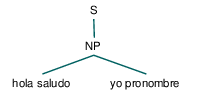

In [79]:
chunked

In [109]:
text = nltk.Text(word.lower() for word in nltk.corpus.brown.words())


No matches


In [125]:
text.similar("he")
tagged_token = nltk.tag.str2tuple("amor/mia")
print(tagged_token)
print(dir(tagged_token))
tupla = tuple(["amor","mia"])
algo = {}
print(dir(algo))


it i she they there we you that this and what which one is was who not
the then had
('amor', 'MIA')
['__add__', '__class__', '__contains__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'count', 'index']
['__class__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'clear', 'copy', 'fromkeys', 'get', 'items', 'keys', 'pop', 'popitem', 'setdefault',

In [138]:
nltk.corpus.cess_esp.readme()

'CESS-ESP and CESS-CAT TREEBANK\n\nThe Universitat de Barcelona (CLiC-UB), the Universidad de Alicante\n(UA), the Universitat PolitÃšcnica de Catalunya (UPC), and the Euskal\nHerriko Unibertsitatea (EHU-UPV) are the sole and exclusive owners of\nthe CESS-Esp treebank.  Information for this corpus can be found at:\nhttp://www.lsi.upc.edu/~mbertran/cess-ece2/\n\nThe goal of the CESS-ECE project is to create three corpora, one for\nSpanish (CESS-ESP), one for Catalan (CESS-Cat) and one for Basque\n(CESS-EUS), of 500,000 words for CESS-Esp and CESS-Cat and 350,000\nwords for the CESS-Eus. These corpora will be tagged in two ways:\nsyntactically (with constituents and functions for CESS-Esp and\nCESS-Cat and with dependencies for CESS-Eus) and semantically (with\nWordNet synsets). This project is based on resources from 3LB Project\n(FIT 150500-2002-244), where 100,000 words per language were annotated\nin the same way.\n\nThe version distributed with NLTK are syntactic treebanks (with\ncon

In [154]:
nltk.corpus.cess_esp.tagged_words()

[('El', 'da0ms0'), ('grupo', 'ncms000'), ...]

In [182]:
raw = "Me gusta todo como huevos verdes y jamon. No le gustan a Sam, yo soy!"
tokens = nltk.word_tokenize(raw)
nltk.DefaultTagger("NN").tag(tokens)

[('Me', 'NN'),
 ('gusta', 'NN'),
 ('todo', 'NN'),
 ('como', 'NN'),
 ('huevos', 'NN'),
 ('verdes', 'NN'),
 ('y', 'NN'),
 ('jamon', 'NN'),
 ('.', 'NN'),
 ('No', 'NN'),
 ('le', 'NN'),
 ('gustan', 'NN'),
 ('a', 'NN'),
 ('Sam', 'NN'),
 (',', 'NN'),
 ('yo', 'NN'),
 ('soy', 'NN'),
 ('!', 'NN')]